In [1]:
%pylab inline

import math
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Scores

In [2]:
# entropy of a given list of probabilities
def H(prob):
    if not 0.99999 <= np.sum(prob) <= 1.0001:
        print("Probabilities must sum to 1.0. Use 'normalize(arr)'.")
        return 
    
    _s = 0
    for i in prob:
        if(i > 0):
            _s += i*math.log2(1.0/i)
    return _s

In [3]:
# returns visual information
#  internal VI := probabilities are selected from the same row 
#  external VI := probabilities are selected from the same column 
def VI(prob, c = None):
    if c == None:
        c = max_H(len(prob))
    return c - H(normalize(prob))

### Utilities

In [4]:
# returns the "max entropy" for a list of "n" elements
def max_H(n):
    return H(np.array([1/n]*n))

In [5]:
# normalizes "prob"
def normalize(prob):
    return prob / np.sum(prob)

In [6]:
# flattens a grouped probability list
def flat(arr):
    return [i for tup in arr for i in tup]

### Calculate all scores

In [7]:
# calculates "VI_int" and "VI_ext" scores from visual entity matrix "O"
# gene = gene index                        (row)
# param = [ group_index, param_index ]     (column)
def calculate_VIs(O, gene, param):
    c = max_H(max(len(O), len(flat(O[gene,:]))))
    VI_int = VI(normalize( flat(O[gene,:]) ), c)
    VI_ext = VI(normalize( [i[param[1]] for i in O[:,param[0]]] ), c)
    return VI_int, VI_ext

In [8]:
def calculate_pareto(vi_i_p, vi_e_p, vi_i, vi_e):
    c_i = vi_i - vi_i_p
    c_e = vi_e - vi_e_p
    
    if c_i < 0 or c_e < 0:
        return -1
    elif c_i > 0 or c_e > 0:
        return 1
    else:
        return 0

### Mutation method

In [9]:
# mutates the given visual entity matrix "0"
def mutate(O, ran):
    def _mut(mat, gene_index=None, index=None, value=None):
        # copy the matrix
        _O = mat.copy()

        ## choose a gene strip randomly
        if gene_index is None:
            gene_index = random.randint(0, len(_O))
        gene = _O[gene_index]

        ## choose a parameter in gene strip randomly
        if index is None:
            group_index = random.randint(0, len(gene))
            index = ( group_index, random.randint(0, len(gene[group_index])) )

        ## calculate prior VI scores
        VI_i_p, VI_e_p = calculate_VIs(_O, gene_index, index)

        ## choose a mutation value randomly
        if value is None:
            value = random.random()*ran#*gene[index[0]][index[1]]

        ## choose an operation randomly (add(1), substract(-1), no_change(0))
        operation = random.choice([-1,0,1])

        ## choose one neighbor randomly and adjust its value (left(-1), right(1))
        neighbor = random.randint(0, len(gene[index[0]]))
        while neighbor == index[1]:
            neighbor = random.randint(0, len(gene[index[0]]))

        ## apply mutation to the gene
        gene[index[0]][index[1]] += operation*value
        gene[index[0]][neighbor] += -operation*value

        ## calculate VI scores
        VI_i, VI_e = calculate_VIs(_O, gene_index, index)

        ## calculate decisions
        pareto = calculate_pareto(VI_i_p, VI_e_p, VI_i, VI_e)
        
        # -1 -> pick different gene
        #  0 -> pick different mutation value
        #  1 -> accept mutation
        if pareto == -1:
            return _mut(mat)
        elif pareto == 0:
            return _mut(mat, gene_index=gene_index, index=index)
        elif pareto == 1:
            return _O
        
    try:
        return _mut(O)
    except RecursionError as re:
        print(".", end='')
        return O

### Run evolution

In [179]:
## evolve 'O' for 'n' iterations
def evolve(O, size, n=50, range=1):
    _O = O.copy()

    # run n iterations
    for _ in np.arange(n):
        # mutates the matrix
        _O = mutate(_O, range)
    
    # balance negatives
    for gene in _O:
        for i, gene_strip in enumerate(gene):
            sum = size[i]
            gene_strip = [abs(i) for i in gene_strip]
            gene[i] = [i*sum/np.sum(gene_strip) for i in gene_strip]
            
    # returns evolved matrix
    return _O

### Show 2D

In [466]:
# displays compositions as image
def show_comp(O, size=(400,400), legend=False, grids=False):
    im = np.ones(size[:2])
    
    ## rectangles
    for rect_xy in O:
        r_x = rect_xy[0]
        r_y = rect_xy[1]
        
        sub_im = im[int(r_y[0]):int(r_y[0]+r_y[1]),
                    int(r_x[0]):int(r_x[0]+r_x[1])]
        im[int(r_y[0]):int(r_y[0]+r_y[1]),
           int(r_x[0]):int(r_x[0]+r_x[1])] = np.logical_xor(sub_im, 1).astype(int)
    
    
    ## calculate subgrids
    coords = np.zeros([shape(O[0])[0], 1]).tolist()
    for gene in O:
        for i, gene_strip in enumerate(gene):
            coords[i].extend([gene_strip[0],gene_strip[0]+gene_strip[1]])
    for i in arange(len(coords)):
        coords[i].sort()
        
    ## determine which rectangles are black
    blacks = [False]*(len(coords[0])*len(coords[1]))
    for i in arange(len(blacks)):
        y = i//len(coords[0])
        x = i%len(coords[0])
        
        _x1 = coords[0][x]
        _x2 = coords[0][x+1] if len(coords[0]) > x+1 else size[0]
            
        _y1 = coords[1][y]
        _y2 = coords[1][y+1] if len(coords[1]) > y+1 else size[1]
        
        if im[int((_y1+_y2)*0.5), int((_x1+_x2)*0.5)] == 0:
            blacks[i] = True
    
    
    ## grid lines
    if grids:
        for rect_xy in O:
            r_x = rect_xy[0]
            r_y = rect_xy[1]
        
            # columns
            im[:,int(r_x[0])] = 0
            im[:,int(r_x[0]+r_x[1])] = 0
            # rows
            im[int(r_y[0]),:] = 0
            im[int(r_y[0]+r_y[1]),:] = 0
    
    imshow(im, cmap='gray')
    if legend is True:
        colorbar()
    
    return coords, blacks

### Show 3D

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [13]:
def create_voxel(O, size=(30,30,30)):
    # create voxels
    voxels = np.zeros(size[:3])
    
    # blocks
    for rect_xyz in O:
        r_x = rect_xyz[0]
        r_y = rect_xyz[1]
        r_z = rect_xyz[2]
        
        sub_v = voxels[int(r_z[0]):int(r_z[0]+r_z[1]),
                       int(r_y[0]):int(r_y[0]+r_y[1]),
                       int(r_x[0]):int(r_x[0]+r_x[1])]
        voxels[int(r_z[0]):int(r_z[0]+r_z[1]),
               int(r_y[0]):int(r_y[0]+r_y[1]),
               int(r_x[0]):int(r_x[0]+r_x[1])] = np.logical_xor(sub_v, 1).astype(int)
        
    return voxels

In [14]:
# show one composition
def show_voxel(O, size=(30,30,30)):
    fig = plt.figure(figsize=(5,4))
    ax = fig.gca(projection='3d')
    ax.voxels(create_voxel(O, size=size))
    plt.show()

### Create Matrices

In [150]:
# total size of the image
SIZE = (300, 300)

# 5 compositions (2D) [(x1,x2-x1,x3-x2-x1), (y1,y2-y1,y3-y2-y1)]
O = np.array([[(100,100,100), (100,100,100)], # (100,100,100)], # for 3D 
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)],
              [(100,100,100), (100,100,100)]])

In [16]:
# create 'n' compositions with 9 grid cells
def create_compositions(n, ndim=2, size=(300,300)):
    return np.ones((n, ndim, 3))*(size[0]//3)

## Testing

#### 2D compositions
Creates and runs evolutions for 2D compositions. `grids=True` argument on `show_comp` draws the gridlines.

In [462]:
SIZE = (200,200)
O = create_compositions(2)

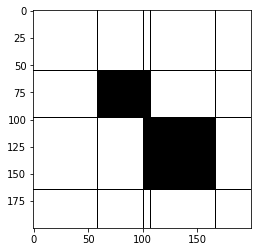

In [469]:
_O = evolve(O, SIZE, n=100, range=5.0)
show_comp(_O, size=SIZE, grids=True);

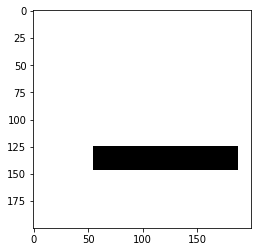

In [473]:
_O = evolve(O, SIZE,  n=1000, range=1.0)
show_comp(_O, size=SIZE, grids=False);

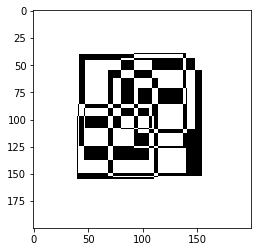

In [213]:
_O = evolve(O, SIZE,  n=2000, range=1.0)
show_comp(_O, size=SIZE)

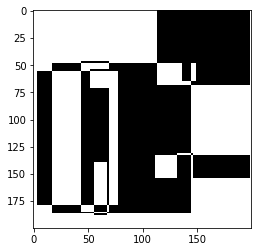

In [216]:
_O = evolve(O, SIZE, n=5000, range=1.0)
show_comp(_O, size=SIZE, grids=False)

#### 3D Compositions
Creates and runs evolutions for 3D compositions. Size shouldn't be too big. 

In [199]:
SIZE = (30,30,30)
O_3D = create_compositions(20, 3, SIZE)

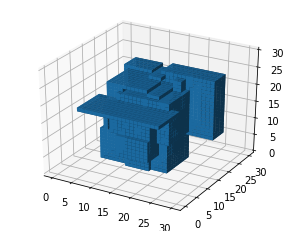

In [200]:
_O_3D = evolve(O_3D, SIZE, n=100, range=5.5)
show_voxel(_O_3D, size=SIZE)

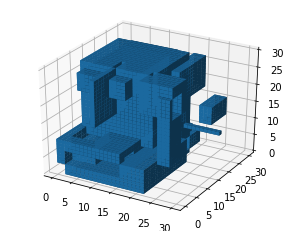

In [201]:
_O_3D = evolve(O_3D, SIZE, n=1000, range=1.5)
show_voxel(_O_3D, size=SIZE)

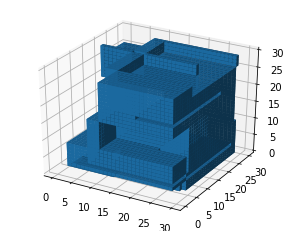

In [204]:
_O_3D = evolve(O_3D, SIZE, n=2000, range=1.0)
show_voxel(_O_3D, size=SIZE)

## Cropping images with visual composition data

Read image data

In [475]:
im = imread("im/tuzla.jpg")

In [479]:
shape(im)

(626, 670, 3)

Evolve a composition

In [544]:
# SIZE = (shape(im)[0], shape(im)[1])
SIZE = (200, 200)
O = create_compositions(10)

In [545]:
_O = evolve(O, SIZE, n=100, range=5.0)

441


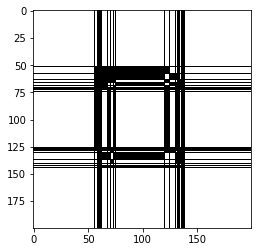

In [549]:
coords, blacks = show_comp(_O, size=SIZE, grids=True)
print(len(blacks))

In [550]:
from skimage import filters

def chop_image():
    x_scale = shape(im)[0]/SIZE[0]
    y_scale = shape(im)[1]/SIZE[1]

    parts = []
    for i in arange(len(blacks)):
        y = i//len(coords[0])
        x = i%len(coords[0])

        _x1 = coords[0][x]
        _x2 = coords[0][x+1] if len(coords[0]) > x+1 else SIZE[0]

        _y1 = coords[1][y]
        _y2 = coords[1][y+1] if len(coords[1]) > y+1 else SIZE[1]

        _x1 *= x_scale
        _x2 *= x_scale
        _y1 *= y_scale
        _y2 *= y_scale

        parts.append(im[int(_y1):int(_y2), int(_x1):int(_x2)])
        if blacks[i]:
            parts[i] = filters.sobel(parts[i])
            
    return parts

In [553]:
def show_chopped_images(parts):
    f = plt.figure(figsize=(20,15))
    for i in range(len(blacks)):
        f.add_subplot(len(coords[1]), len(coords[0]), i+1)
        plt.imshow(parts[i])

    plt.show(block=True)

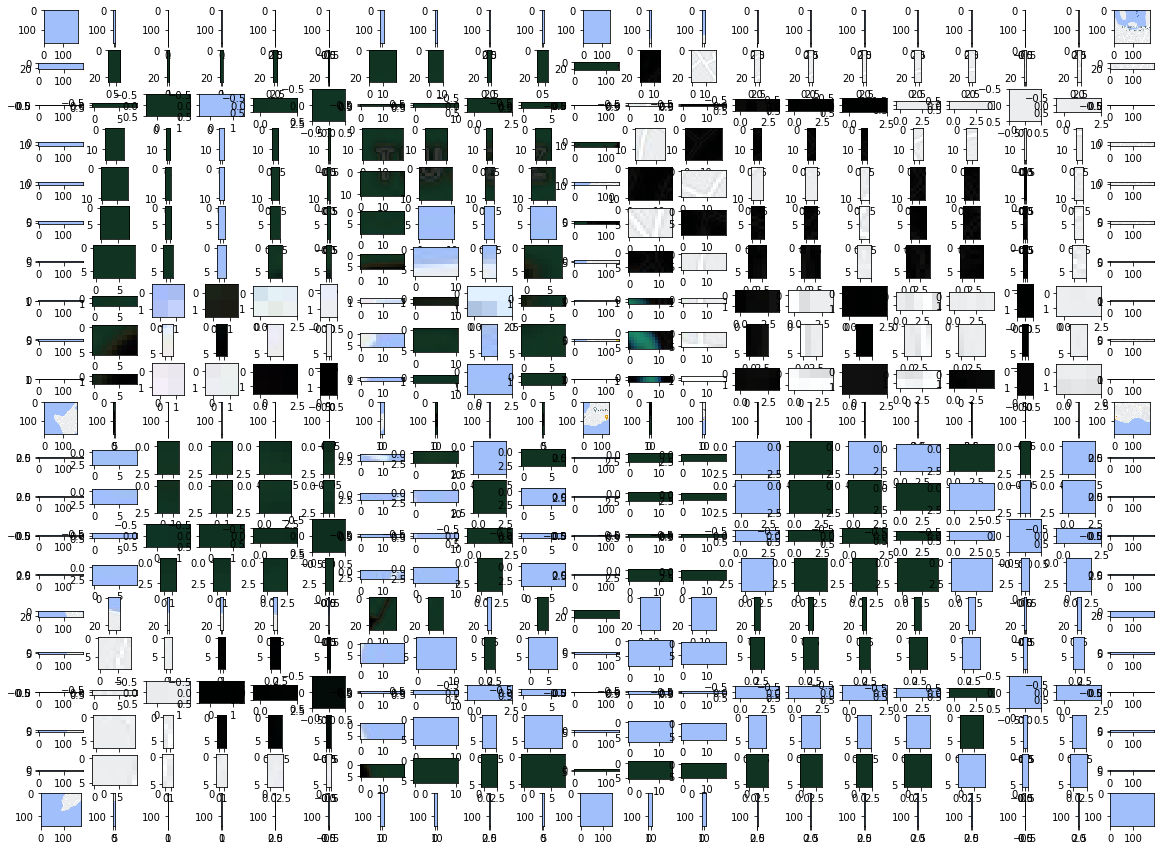

In [554]:
show_chopped_images(chop_image())

441


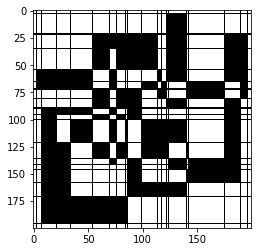

In [557]:
_O = evolve(O, SIZE, n=1000, range=4.0)
coords, blacks = show_comp(_O, size=SIZE, grids=True)
print(len(blacks))

ValueError: zero-size array to reduction operation minimum which has no identity

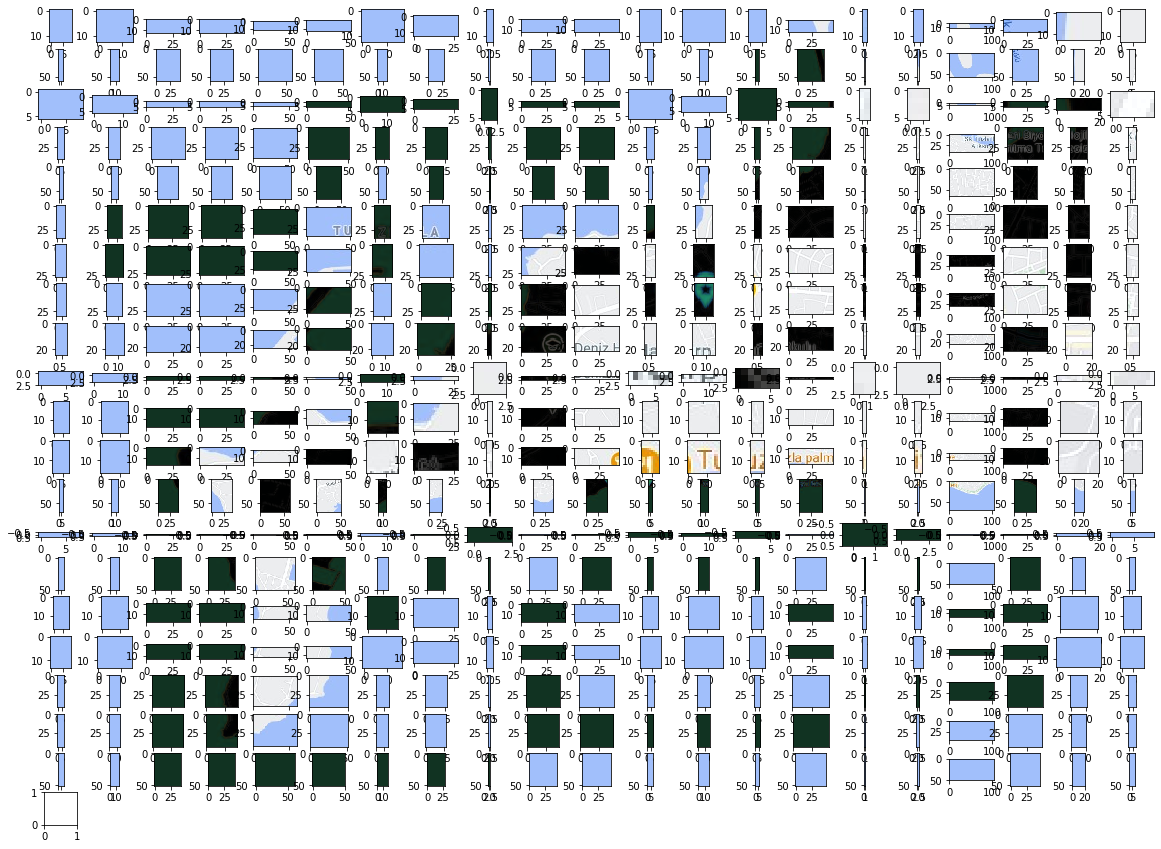

In [558]:
show_chopped_images(chop_image())